# A04-Q2: Combatting Overfitting

## Preliminaries

In [498]:
# Standard imports
import numpy as np
import torch
import matplotlib.pylab as plt
import copy
from random import random

In [499]:
mat = torch.ones(10)*(1-0.7)
print(mat)
c=(torch.bernoulli(mat))
print(c)
b = torch.ones(5)/(1-0.7)
print(torch.outer(c,b))

tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


# Dataset

In [500]:
class DividedPlane(torch.utils.data.Dataset):
    def __init__(self, n=100, noise=0.1, seed=None):
        a = torch.tensor([-0.4, 0.5, 0.15]) #torch.rand((3,))
        def myfunc(x):
            y = a[0]*x[:,0] + a[1]*x[:,1] + a[2]
            return y
        self.x = torch.rand((n,2))*2. - 1.
        y = myfunc(self.x) + noise*torch.normal( torch.zeros((len(self.x))) )
        self.y = (y>0.).type(torch.float)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.y.reshape( (len(self.y),1) )
    
    def plot(self, labels=None, *args, **kwargs): 
        X = self.inputs()
        if labels is None:
            labels = self.targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        if len(labels[0])>1:
            # one-hot labels
            cidx = torch.argmax(labels, axis=1)
        else:
            # binary labels
            cidx = (labels>0.5).type(torch.int)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,0].detach(), X[:,1].detach(), color=colours, marker='.')


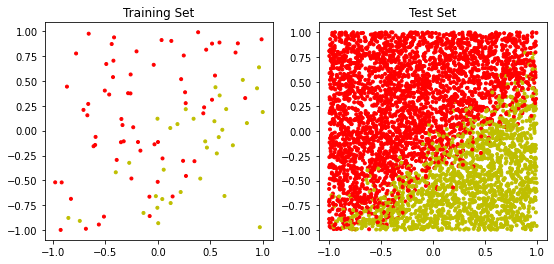

In [501]:
train = DividedPlane(n=100, noise=0.2, seed=165)
test = DividedPlane(n=5000)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); train.plot(); plt.title(f'Training Set');
plt.subplot(1,2,2); test.plot(); plt.title(f'Test Set');

# A: `Dropout` layer

In [502]:
class Dropout(torch.nn.Module):
    '''
     lyr = Dropout()
     
     Creates a dropout layer in which each node is set to zero
     with probability lyr.dropprob.
     
     Usage:
       lyr = Dropout()
       lyr.set_dropprob(p) # set the dropout probability to p
       y = lyr(z)          # sets each node to 0 with probability p
       
     The input, z, contains one sample per row. So the dropout is
     performed independently on each row of z.
    '''
    def __init__(self):
        super().__init__()
        self.dropprob = 0.
        
    def set_dropprob(self, p):
        self.dropprob = p
        
    def forward(self, z):
        # Drop nodes with prob dropprob
        
        
        #===== YOUR CODE HERE =====
        with torch.no_grad():
            nrow = z.shape[0]
            ncol = z.shape[1]
            probMat = torch.mul( torch.ones(nrow),(1-self.dropprob))
            indicatorMat = torch.bernoulli(probMat)
            helperMat = torch.div( torch.ones(ncol), (1-self.dropprob))
            tensorMat =  torch.outer(indicatorMat, helperMat).squeeze()
        return torch.mul(z, tensorMat)
        
        


In [503]:
# Test for Dropout layer
b = torch.randn((200,1000),requires_grad=True)
z = torch.ones((200,1000),requires_grad=True)
drop_layer = Dropout()
drop_layer.set_dropprob(0.5)
y = drop_layer(torch.add(z,b))
g=sum(sum(y))
print(g)
g.backward()

print(b.grad)
print(z.grad)

drop_fraction = (torch.sum(y==0.)*100.)/torch.numel(y)
print(f'Dropped {drop_fraction:.1f}%')
print(f'Expected output is {torch.sum(y)}, which should be close to {torch.sum(z)}')

tensor(208294.2188, grad_fn=<AddBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.]])
Dropped 48.0%
Expected output is 208294.25, which should be close to 200000.0


# B: `RobustNetwork`
* Implement regularization by weight decay <br>
* Integrate the dropout layer into learning

In [504]:
class RobustNetwork(torch.nn.Module):
    def __init__(self, nodes=100):
        super().__init__()
        self.lyrs = torch.nn.ModuleList()
        self.lyrs.append(torch.nn.Linear(2, nodes))
        self.lyrs.append(torch.nn.ReLU())
        self.lyrs.append(torch.nn.Linear(nodes, nodes))
        self.lyrs.append(torch.nn.Sigmoid())
        self.drop_lyr = Dropout()    # <-- Create Dropout layer
        self.lyrs.append(self.drop_lyr)  # Add it to the list
        self.lyrs.append(torch.nn.Linear(nodes, 1))
        self.lyrs.append(torch.nn.Sigmoid())
        self.loss_fcn = torch.nn.BCELoss(reduction='mean')
    
    def forward(self, x):
        y = x
        for lyr in self.lyrs:
            y = lyr(y)
        return y

    
    def learn(self, x, t, epochs=100, lr=0.1, weight_decay=0., dropprob=0.):
        losses = []
        for epoch in range(epochs):
            self.drop_lyr.set_dropprob(dropprob)
            y = self(x)
            # add loss due to weight decay
            loss_from_param = torch.tensor([0], dtype=torch.float) 
            for param in self.parameters():
                loss_from_param = torch.add(loss_from_param, param.norm(2)**2*weight_decay/2 )   
            loss =torch.add( self.loss_fcn(y.squeeze(), t.squeeze()), loss_from_param)
            self.zero_grad()
            loss.backward()

            with torch.no_grad():
                for p in self.parameters():
                    p -= lr*p.grad
                # we are calculating actual loss, so we set droprate to 0
                self.drop_lyr.set_dropprob(0.)
                y = self(x)
                loss = self.loss_fcn(y.squeeze(), t.squeeze())

                losses.append(loss.item())

        plt.plot(np.array(losses))
        plt.yscale('log'); plt.xlabel('Epochs'); plt.ylabel('Log Loss');
        print(f'Final loss = {loss}')
        return losses

# Train and test

In [505]:
net_orig = RobustNetwork(nodes=250)

# Duplicate the network for apples-to-apples comparison
net = copy.deepcopy(net_orig)
rnet = copy.deepcopy(net_orig)
dnet = copy.deepcopy(net_orig)

# Set come common parameters
lr = 0.5
n_epochs = 5000

### Saving and loading models
You might find it helpful to save and load your networks. The lines below save the network, including the connection weights and biases.

Note that the pertinent classes have to be declared before you can load an object of that class.

### Train the models

Final loss = 0.19594305753707886


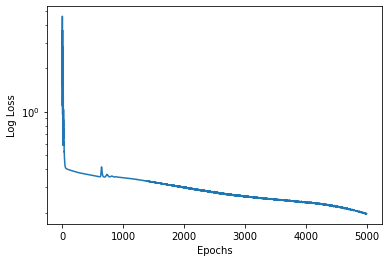

In [506]:
# No effort to guard against overfitting
losses = net.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lr)


Final loss = 0.45231449604034424


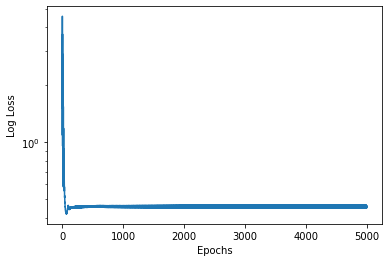

In [507]:
# L2 regularization
rlosses = rnet.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lr, weight_decay=0.004)

Final loss = 0.3195672929286957


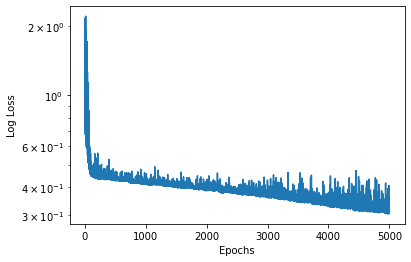

In [508]:
# Dropout
dnet = copy.deepcopy(net_orig)

dlosses = dnet.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=0.2, dropprob=0.5)

### Test the models
#### Let's see what the decision boundaries look like.

In [509]:
test.inputs().shape

torch.Size([5000, 2])

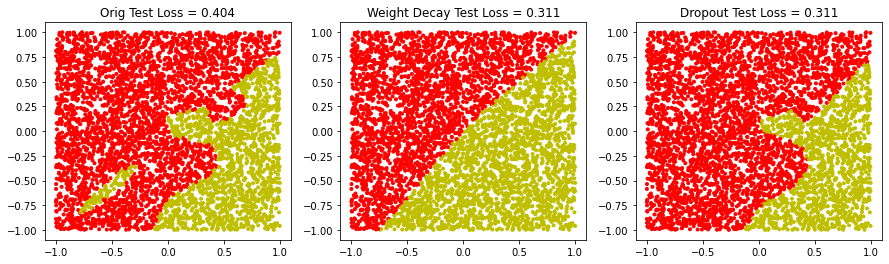

In [510]:
# Compute test loss
y = net(test.inputs()); test_loss = net.loss_fcn(y, test.targets())
ry = rnet(test.inputs()); rtest_loss = rnet.loss_fcn(ry, test.targets())
dy = dnet(test.inputs()); dtest_loss = dnet.loss_fcn(dy, test.targets())

# Display the results
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
test.plot(labels=net(test.inputs())); plt.title(f'Orig Test Loss = {test_loss:.3f}')
plt.subplot(1,3,2)
test.plot(labels=rnet(test.inputs())); plt.title(f'Weight Decay Test Loss = {rtest_loss:.3f}')
plt.subplot(1,3,3)
test.plot(labels=dnet(test.inputs())); plt.title(f'Dropout Test Loss = {dtest_loss:.3f}');